In [2]:
#topology tester...
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'


import jax
import jax.numpy as jnp
from jax import lax
import jaxkd as jk 

import jax
import jax.numpy as jnp
from jax import lax
import jaxkd as jk

In [4]:


LOGIT_CLIP = 30.0
MASK_LOGIT = -30.0

def _ensure_xyz32(pos):
    pos = jnp.asarray(pos).astype(jnp.float32, copy=False)
    if pos.ndim != 2: raise ValueError("pos must be (N,2/3)")
    N, D = pos.shape
    if D == 3: return pos
    if D == 2: return jnp.concatenate([pos, jnp.zeros((N,1), pos.dtype)], 1)
    raise ValueError("pos must be (N,2/3)")

def _knn_neighbors(pos32, k, cuda=False):
    tree = jk.build_tree(pos32, cuda=cuda)
    nbr_idx, _ = jk.query_neighbors(tree, pos32, k=k, cuda=cuda)
    return nbr_idx  # [N,k] (may contain -1)

def _edge_logits_from_knn(pos32, nbr_idx, b, alpha):
    N, k = nbr_idx.shape
    i = jnp.repeat(jnp.arange(N, dtype=jnp.int32), k)
    j = nbr_idx.reshape(-1)
    valid = (j >= 0)
    j_safe = jnp.where(valid, j, 0)

    diff = pos32[i] - pos32[j_safe]
    d2   = jnp.sum(diff * diff, axis=1)
    b2   = jnp.asarray(b, pos32.dtype)**2
    z    = alpha * (b2 - d2) / (jnp.abs(b2) + 1e-12)
    z    = jnp.where(valid, z, MASK_LOGIT)
    return jnp.clip(z, -LOGIT_CLIP, LOGIT_CLIP)   # [N*k]

def _binary_concrete_st(key, logits, tau=0.5):
    # Gumbel noise
    u = jax.random.uniform(key, logits.shape, minval=1e-6, maxval=1-1e-6)
    g = jnp.log(u) - jnp.log1p(-u)
    y_soft = jax.nn.sigmoid((logits + g) / jnp.asarray(tau, logits.dtype))
    y_hard = (y_soft > 0.5).astype(jnp.int32)
    # straight-through estimator
    y_st = y_hard + jax.lax.stop_gradient(y_soft - y_hard)
    return y_st, y_hard, y_soft

def _cc_label_prop_dense_masked_st(pos32, nbr_idx, b, max_iters, edge_on_flat):
    N, k = nbr_idx.shape
    labels0 = jnp.arange(N, dtype=jnp.int32)
    i   = jnp.arange(N, dtype=jnp.int32)
    src = jnp.repeat(i, k)
    dst = nbr_idx.reshape(-1)

    dst_ge0   = (dst >= 0)
    non_self  = (src != jnp.where(dst_ge0, dst, 0))
    valid_idx = dst_ge0 & non_self
    dst_safe  = jnp.where(dst_ge0, dst, 0)

    d  = pos32[src] - pos32[dst_safe]
    b2 = jnp.asarray(b, pos32.dtype)**2
    within = jnp.sum(d * d, axis=1) <= b2

    edge_on = (edge_on_flat > 0)
    valid = valid_idx & within & edge_on

    big = jnp.int32(N)
    def one_iter(labels):
        incoming = jnp.full((N,), big, dtype=jnp.int32)
        incoming = incoming.at[dst_safe].min(jnp.where(valid, labels[src], big))
        incoming = incoming.at[src].min(jnp.where(valid, labels[dst_safe], big))
        return jnp.minimum(labels, incoming)

    return lax.fori_loop(0, max_iters, lambda _, lab: one_iter(lab), labels0)

def _effective_halo_count(labels, *, min_mass=1.0, weights=None):
    # JIT/vmap-safe counting with static-N accumulators
    N = labels.shape[0]
    w = jnp.ones((N,), jnp.float32) if weights is None else weights.astype(jnp.float32)

    K = jnp.max(labels) + 1
    idx = jnp.arange(N, dtype=jnp.int32)
    in_range = (idx < K)

    mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
        jnp.where(labels >= 0, w, 0.0)
    )
    keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
    return jnp.sum(keep_full).astype(jnp.float32)

In [5]:
def one_sample_gumbel_terms_positions(key, pos_params, *,
                                      b, alpha, k, max_iters,
                                      tau=0.5, min_mass=1.0, weights=None,
                                      cuda=False, sign=+1):
    """
    sign = +1 -> minimize #halos; sign = -1 -> maximize #halos.
    No REINFORCE term here; gradients flow via ST-Concrete through logits -> positions.
    """
    pos32   = _ensure_xyz32(pos_params)
    nbr_idx = _knn_neighbors(pos32, k, cuda=cuda)

    logits = _edge_logits_from_knn(pos32, nbr_idx, b, alpha)   # [N*k]
    y_st, y_hard, _ = _binary_concrete_st(key, logits, tau=tau)

    # Use HARD mask for CC forward pass (keeps topology exact in forward)
    labels = _cc_label_prop_dense_masked_st(pos32, nbr_idx, b, max_iters, y_hard)

    # Count halos with min_mass
    K_eff  = _effective_halo_count(labels, min_mass=min_mass, weights=weights)
    L      = sign * K_eff
    # Return just L; the grads wrt positions flow via 'y_st' path (because of ST construction).
    # To get that, we need to ensure 'y_hard' doesn't cut the gradient path:
    # Replace y_hard with y_st in 'valid' computation. Quick way: re-run CC with y_st in backward only.
    # We'll do a detach-swap trick below in the wrapper.
    return L, (logits, y_st, y_hard, nbr_idx)

In [7]:
def one_sample_gumbel_terms_positions(key, pos_params, *,
                                      b, alpha, k, max_iters,
                                      tau=0.5, min_mass=1.0, weights=None,
                                      cuda=False, sign=+1):
    pos32   = _ensure_xyz32(pos_params)
    nbr_idx = _knn_neighbors(pos32, k, cuda=cuda)

    logits = _edge_logits_from_knn(pos32, nbr_idx, b, alpha)
    y_st, _, _ = _binary_concrete_st(key, logits, tau=tau)   # use ST mask directly

    labels = _cc_label_prop_dense_masked_st(pos32, nbr_idx, b, max_iters, y_st)

    K_eff  = _effective_halo_count(labels, min_mass=min_mass, weights=weights)
    L      = sign * K_eff
    return L

def loss_and_grad_positions_gumbel(pos_params, key, *,
                                   b, alpha=5.0, k=16, max_iters=50,
                                   tau=0.5, min_mass=1.0, weights=None,
                                   S=16, cuda=False, sign=+1):
    """
    Returns (mean_L, grad wrt pos_params) using ST-Concrete (no REINFORCE term).
    """
    keys = jax.random.split(key, S)

    def batch_objective(pp):
        Ls = jax.vmap(lambda kk: one_sample_gumbel_terms_positions(
            kk, pp, b=b, alpha=alpha, k=k, max_iters=max_iters,
            tau=tau, min_mass=min_mass, weights=weights, cuda=cuda, sign=sign))(keys)
        return jnp.mean(Ls)

    mean_L, g = jax.value_and_grad(batch_objective)(pos_params)
    return mean_L, g

In [56]:
import fof.fofkd as fof

def _effective_halo_count(labels, min_mass=1.0, weights=None):
    """Count halos whose mass >= min_mass. Uses static-N buffers (JIT/vmap-safe)."""
    N = labels.shape[0]
    w = jnp.ones((N,), jnp.float32) if weights is None else weights.astype(jnp.float32)

    K = jnp.max(labels) + 1
    idx = jnp.arange(N, dtype=jnp.int32)
    in_range = (idx < K)

    mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
        jnp.where(labels >= 0, w, 0.0)
    )
    keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
    return jnp.sum(keep_full).astype(jnp.float32)  # scalar


def count_halos_deterministic(pos, b, k, max_iters, min_mass=1.0, cuda=False, weights=None):
    pos32 = _ensure_xyz32(pos)
    # Your existing hard FoF:
    labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos32, b=b, k=k, max_iters=max_iters, cuda=cuda)
    # Count with min-mass; labels are already 0..K-1
    return _effective_halo_count(labels, min_mass=min_mass, weights=weights)

def loss_and_grad_positions_gumbel_edges(pos_params, key, *,
                                         b, alpha=3.0, k=16, max_iters=0,   # CC unused
                                         tau=1.0, S=16, min_mass=1.0,cuda=False, sign=+1):
    keys = jax.random.split(key, S)
    pos32 = _ensure_xyz32(pos_params)
    nbr_idx = _knn_neighbors(pos32, k, cuda=cuda)

    def one(kk, pos):
        logits = _edge_logits_from_knn(pos, nbr_idx, b, alpha)
        u = jax.random.uniform(
            kk, shape=logits.shape, dtype=logits.dtype,
            minval=1e-6, maxval=1.0 - 1e-6
        )
       
        g = jnp.log(u) - jnp.log1p(-u)
        y_soft = jax.nn.sigmoid((logits + g) / tau)
        # Max components -> minimize edges => sign = +1
        return sign * jnp.sum(y_soft)   # smooth, nonzero grads

    def batch_obj(p):
        Ls = jax.vmap(lambda kk: one(kk, p))(keys)
        return jnp.mean(Ls)

    mean_L, g = jax.value_and_grad(batch_obj)(pos32)
    return mean_L, g

In [60]:
key = jax.random.PRNGKey(0)
N = 1_000
pos0 = jax.random.uniform(key, (N, 2), minval=0.0, maxval=1.0).astype(jnp.float32)*3

# FoF + Gumbel params
b = 0.1
k = 16
alpha = 5.0
max_iters = 50
min_mass = 5.0
sign = -1           # -1 to maximize clusters, +1 to minimize
tau = 0.7           # start soft-ish


In [61]:
count_halos_deterministic(pos0,b,k,max_iters,min_mass)

Array(41., dtype=float32)

In [64]:
pos_i = _ensure_xyz32(pos0)

In [67]:
# One step
for i in range(0,100):
    L, gpos = loss_and_grad_positions_gumbel_edges(
        pos_i, jax.random.PRNGKey(42),
        b=b, alpha=alpha, k=k, max_iters=max_iters,
        tau=tau, min_mass=min_mass, S=16, cuda=False, sign=sign
    )
    pos_i = pos_i - 1e-5 * gpos
    print(i,count_halos_deterministic(pos_i,b,k,max_iters,min_mass))

0 41.0
1 41.0
2 41.0
3 41.0
4 42.0
5 42.0
6 42.0
7 41.0
8 40.0
9 40.0
10 41.0
11 40.0
12 39.0
13 40.0
14 41.0
15 41.0
16 40.0
17 40.0
18 40.0
19 40.0
20 40.0
21 41.0
22 39.0
23 38.0
24 36.0
25 36.0
26 38.0
27 38.0
28 37.0
29 39.0
30 38.0
31 38.0
32 39.0
33 39.0
34 38.0
35 38.0
36 39.0
37 39.0
38 41.0
39 41.0
40 41.0
41 41.0
42 42.0
43 43.0
44 43.0
45 44.0
46 46.0
47 46.0
48 46.0
49 47.0
50 47.0
51 48.0
52 48.0
53 49.0
54 49.0
55 50.0
56 51.0
57 53.0
58 53.0
59 54.0
60 55.0
61 58.0
62 58.0
63 58.0
64 59.0
65 60.0
66 60.0
67 60.0
68 61.0
69 61.0
70 61.0
71 63.0
72 63.0
73 62.0
74 64.0
75 64.0
76 64.0
77 64.0
78 64.0
79 65.0
80 66.0
81 68.0
82 68.0
83 67.0
84 67.0
85 67.0
86 68.0
87 69.0
88 69.0
89 69.0
90 70.0
91 70.0
92 70.0
93 70.0
94 70.0
95 71.0
96 72.0
97 72.0
98 72.0
99 72.0


In [68]:
labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos_i, b=b, k=k, max_iters=max_iters, cuda=False)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/fof/lib/python3.13/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['sign']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


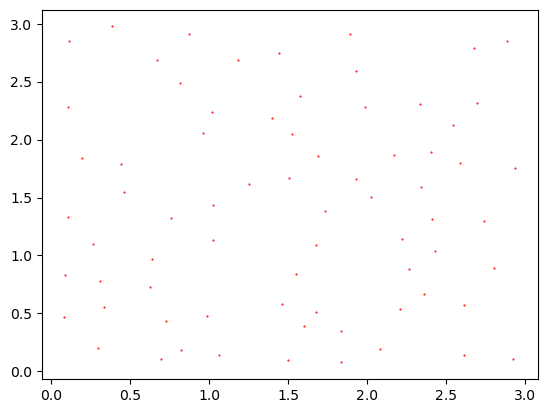

In [69]:
%pylab inline
N = labels.shape[0]

K = jnp.max(labels) + 1
idx = jnp.arange(N, dtype=jnp.int32)
in_range = (idx < K)

mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
    jnp.where(labels >= 0, 1.0, 0.0)
)
keep_full_i = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))

plt.plot(pos_i[:,0][keep_full_i],pos_i[:,1][keep_full_i],"r.",markersize=1)

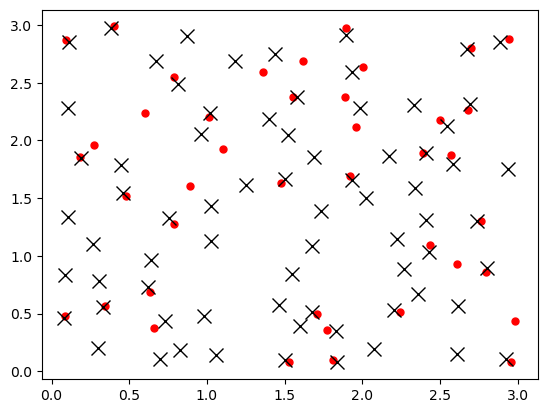

In [70]:
labels, compact_labels, sizes_padded, nC = fof.fof_clusters_jit(pos0, b=b, k=k, max_iters=max_iters, cuda=False)

N = labels.shape[0]

K = jnp.max(labels) + 1
idx = jnp.arange(N, dtype=jnp.int32)
in_range = (idx < K)

mass_full = jnp.zeros((N,), jnp.float32).at[jnp.where(labels >= 0, labels, 0)].add(
    jnp.where(labels >= 0, 1.0, 0.0)
)
keep_full = in_range & (mass_full >= jnp.asarray(min_mass, jnp.float32))
plt.plot(pos0[:,0][keep_full],pos0[:,1][keep_full],"r.",markersize=10)
plt.plot(pos_i[:,0][keep_full_i],pos_i[:,1][keep_full_i],"kx",markersize=10)

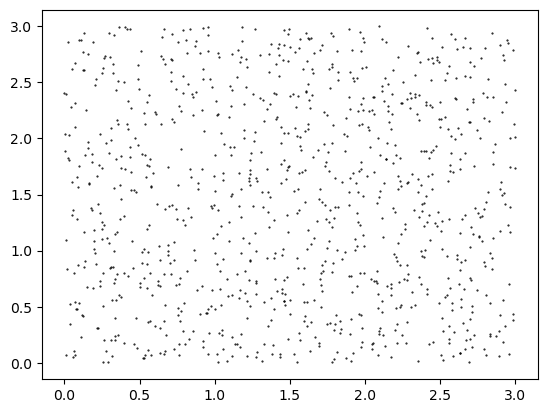

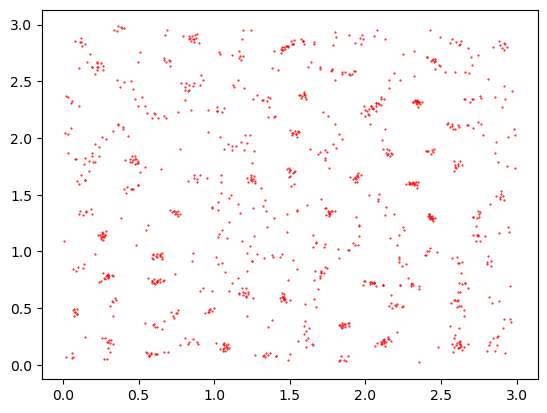

In [71]:
plt.plot(pos0[:,0],pos0[:,1],"k.",markersize=1)
plt.show()
plt.plot(pos_i[:,0],pos_i[:,1],"r.",markersize=1)